# Bayesian Posterior Sampling

When using Bayesian posterior sampling, we want to the posterior, ${\rm P}(M(\vec{\theta}) \vert D)$, of the model ($M(\vec{\theta})$)  given one or more datasets ($D$) (i.e., plugin instances) and one model containing one or more sources with free parameters $\vec{\theta} $ given a likelihood $L(\vec{\theta}) = {\rm P}(D \vert M(\vec{\theta}))$ and prior ${\rm P}(\theta)$ on the parameters. Only the simplest posteriors allow for an analytic solution, thus we must rely on Monte Carlo or nested sampling methods to sample the posterior. 

In 3ML, we currently provide two popular posterior sampling methods: [emcee](https://github.com/dfm/emcee) and [MULTINEST](https://github.com/farhanferoz/MultiNest). If you installed via conda, both packages are available, otherwise, only emcee is included.

## emcee

"[emcee](https://github.com/dfm/emcee) is an extensible, pure-Python implementation of Goodman & Weare's Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler." It uses multiple "walkers" to explore the parameter space of the posterior. For a complete understanding of the capabilites and limitations, we recommend a thorough reading of [Goodman & Weare (2010)](http://msp.org/camcos/2010/5-1/p04.xhtml). Nevertheless we emphasize these N points to keep in mind:

* emcee is for unimodal parameter estimation
* for complex likelihoods and marginal likelihood integration, check out thermodynamic integration (documentation coming soon)



Let's take a look at its usage for a simple likelihood.


In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from threeML import *
from threeML.bayesian.tutorial_material import *

In [2]:
plt.style.use('mike')

Let’s get a BayesianAnalysis object like the one we would have in a normal 3ML analysis. We use a custom function, prepared for this tutorial, which gives a BayesianAnalysis object having a very simple model with one free parameter ($\mu$), and with a likelihood having a very simple shape:

<IPython.core.display.Javascript object>


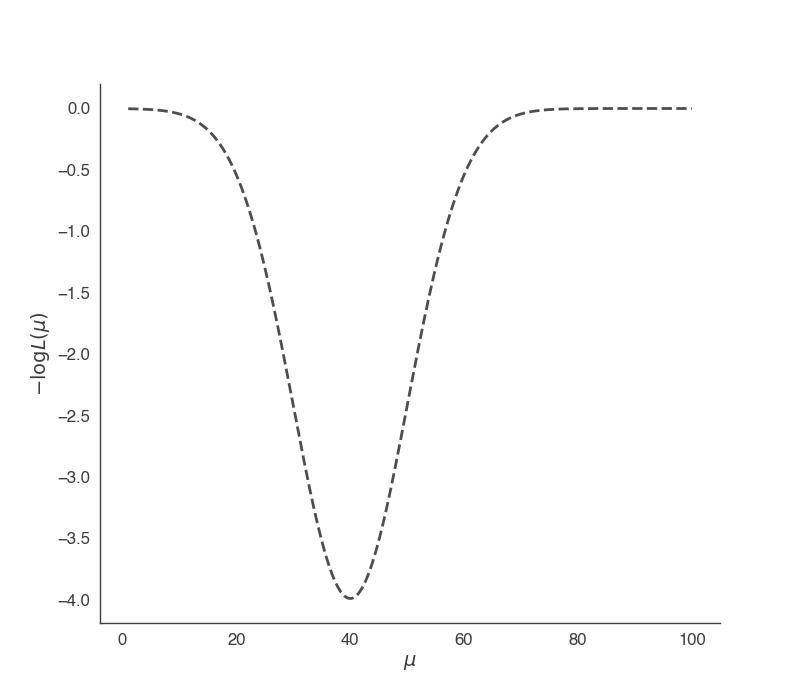

In [6]:
# This returns a BayesianAnalysis object with a simple likelihood function,
# and the corresponding Model instance. These objects are what you will have
# in a typical 3ML analysis. The Model contains one point source, named "test",
# with a spectrum called "simple"
bayes, model = get_bayesian_analysis_object_simple_likelihood()
bayes.set_sampler('emcee')
# Let's look at the likelihood function, which in this illustrative example
# has a very simple shape
_ = plot_likelihood_function(bayes)

We must define a prior fo $\mu$ in order to sample. Let's use a uniform prior from 0 to 100. There are two ways to define this in 3ML:

In [7]:
# This directly assigns the prior
model.test.spectrum.main.shape.mu.prior = Uniform_prior(lower_bound=1, upper_bound=100.)

# Alternatively, we can set an uniformative prior on the parameter's bounds
model.test.spectrum.main.shape.mu.set_uninformative_prior(Uniform_prior)


Ok, we are ready to sample. We will use only 5 walkers for this problem. We need to define a burn_in sample length which is how long we want to run the sampler to approach the target distribution so that we do not include these "learning" samples in our final results. Additionally, we need to declare the number of samples each walker will take.

In [8]:
n_walkers = 5
burn_in = 10
n_samples = 500

bayes.sampler.setup(n_iterations=n_samples,n_burn_in=burn_in,n_walkers=n_walkers )

res = bayes.sample()

100%|██████████| 500/500 [00:00<00:00, 1408.44it/s]



Mean acceptance fraction: 0.742

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Simple.mu,(3.8 -1.0 +0.8) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,3.989422
total,3.989422



Values of statistical measures:



,statistical measures
AIC,-9.978844
BIC,-7.978844
DIC,-3.750087
PDIC,2.016456


<IPython.core.display.Javascript object>


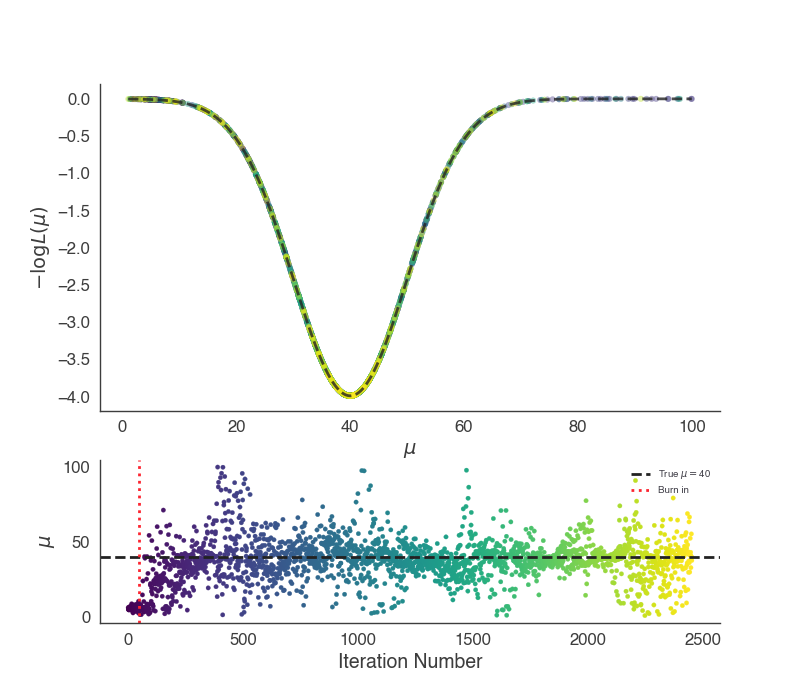

In [9]:
_ = plot_sample_path(bayes,truth=40.,burn_in=n_walkers*burn_in)

We can see that we did not burn in the sampler long enough and we will have part of the burn in included in the results as can be seen in the marginal distribution of $\mu$:

<IPython.core.display.Javascript object>


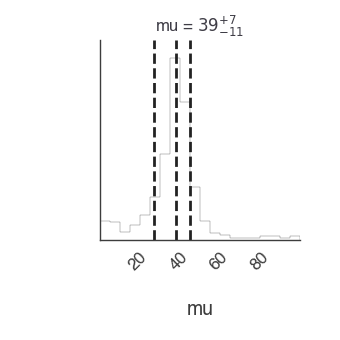

In [10]:
_ = bayes.results.corner_plot()

We could easily run the sampler longer, but let's reset the value of $\mu$ far from the target distribution and try more burn in samples.

In [11]:
model.test.spectrum.main.shape.mu =99


n_walkers = 2
burn_in = 200
n_samples = 500

res = bayes.sample()

100%|██████████| 500/500 [00:00<00:00, 1380.83it/s]



Mean acceptance fraction: 0.7407999999999999

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Simple.mu,(4.0 -0.9 +0.7) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,3.989423
total,3.989423



Values of statistical measures:



,statistical measures
AIC,-9.978845
BIC,-7.978845
DIC,-3.738946
PDIC,2.118753


<IPython.core.display.Javascript object>


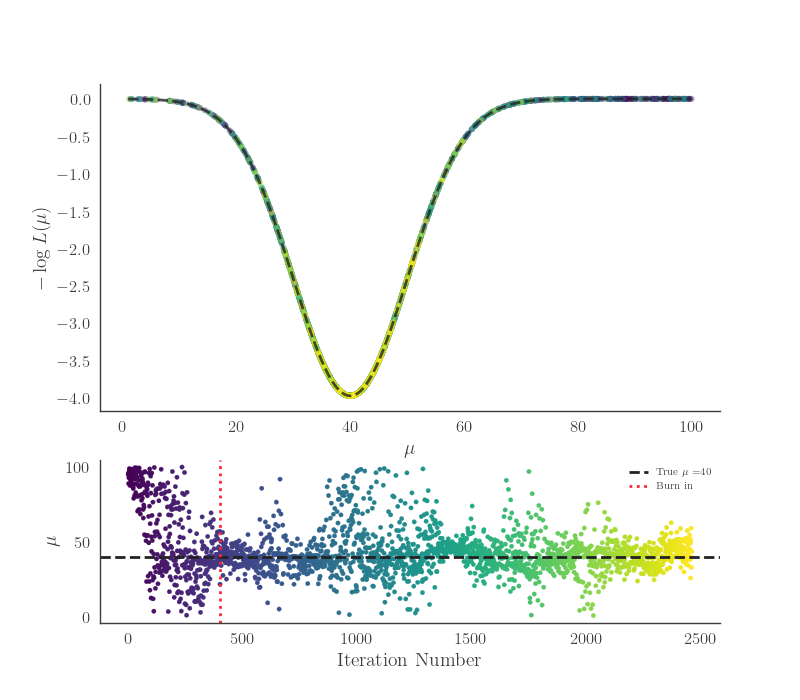

<IPython.core.display.Javascript object>


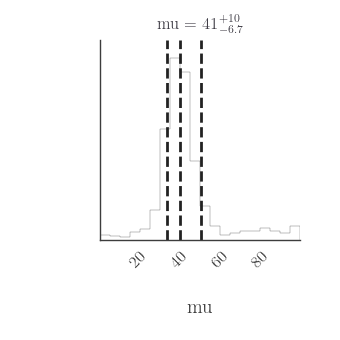

In [18]:
_ = plot_sample_path(bayes,truth=40.,burn_in=n_walkers*burn_in)
_ = bayes.results.corner_plot()

The marginal distribution of the parameter $\mu$ *is* the answer for our parameter. It is the integral of the posterior over all other parameters, $\vec{\phi}$, given the data.

$${\rm P}(\mu \vert D) = \int_{-\infty}^{\infty} {\rm d}\vec{\phi} \; {\rm P}( \mu, \vec{\phi}\vert D )$$

Of course, in our simple model, there are no other parameters. The marginal natuarally includes the dependence of all other parameters and is only equivalent to MLE error estimates under assumptions of Gaussianity and linearity. 

We can sometimes use point-descriptors for the marginal, e.g., mean, median, etc., but when the marginal distribution is not easily symmetric, it can be more descriptive to plot it or speak of its highest posterior density interval:


In [12]:
this_mu = bayes.results.get_variates('test.spectrum.main.Simple.mu')

print(this_mu.highest_posterior_density_interval(cl=.68))
print(this_mu.highest_posterior_density_interval(cl=.95))

(31.67224005194367, 46.98179350848535)
(1.0258270433669878, 65.17269053666413)


### Priors

We have not paid much attention to our prior choice. So far, we have used an uninformative prior (except that we know in our example the range over which the parameter can be found), but what happens if we limit our prior such that we would never find the target distribution?

Let's set a uniform prior such that $\mu \in \{80-100 \}$.

In [13]:
model.test.spectrum.main.shape.mu =99
model.test.spectrum.main.shape.mu.prior = Uniform_prior(lower_bound=80, upper_bound=100)

n_walkers = 2
burn_in = 200
n_samples = 1000

bayes.sampler.setup(n_iterations=n_samples,n_burn_in=burn_in,n_walkers=n_walkers )
res = bayes.sample()

100%|██████████| 1000/1000 [00:00<00:00, 2141.53it/s]


Mean acceptance fraction: 0.842

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Simple.mu,(9.0 +/- 0.7) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,0.001338
total,0.001338



Values of statistical measures:



,statistical measures
AIC,-2.002676
BIC,-0.002676
DIC,-0.000638
PDIC,-0.000302


<IPython.core.display.Javascript object>


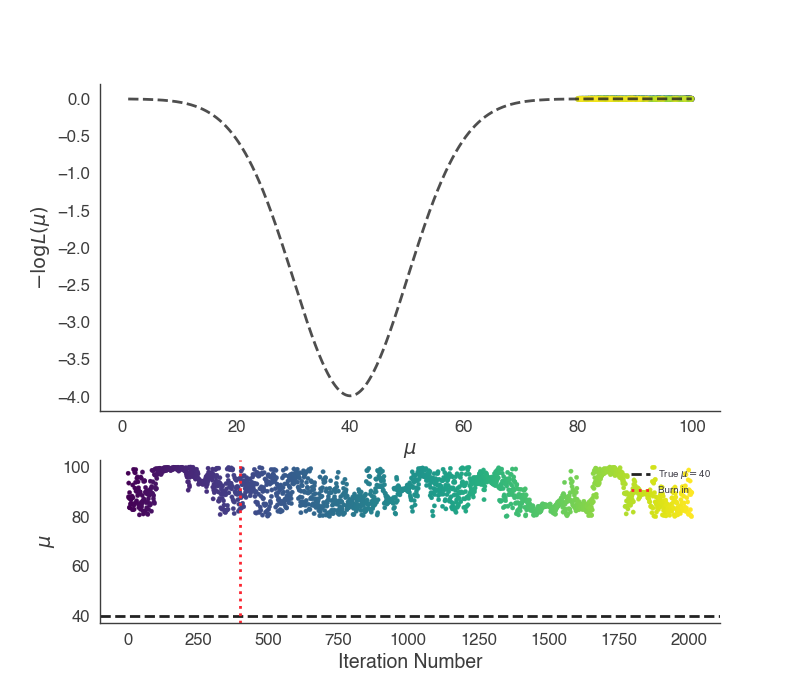

<IPython.core.display.Javascript object>


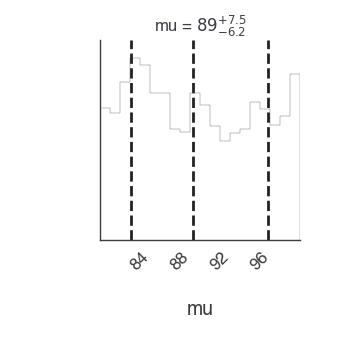

In [14]:
_ = plot_sample_path(bayes,truth=40.,burn_in=n_walkers*burn_in)
_ = bayes.results.corner_plot()

We see that the over this range, the marginal distribution is the same as the prior, i.e., uniformative. The "data" have not updated our information about $\mu$ and thus we cannot conclude anything. This is by design in our example, but if we were to believe that $\mu$ had to be found in the interval $\mu \in\{80-100\}$, the data have not helped us to determine anything.

Let's now look at setting a more informative prior on $\mu$. Suppose from either other measurements or physical insight, we are sure $\mu\sim 30$ with some uncertainty. Then we can impose a Gaussian prior over $\mu$.  

In [15]:
model.test.spectrum.main.shape.mu =99
model.test.spectrum.main.shape.mu.bounds = (None, None)
model.test.spectrum.main.shape.mu.prior = Gaussian(mu=25,sigma=5)

In [16]:
n_walkers = 2
burn_in = 200
n_samples = 1000

bayes.sampler.setup(n_iterations=n_samples,n_burn_in=burn_in,n_walkers=n_walkers )
res = bayes.sample()

100%|██████████| 1000/1000 [00:00<00:00, 2009.05it/s]



Mean acceptance fraction: 0.8009999999999999

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Simple.mu,(3.5 -0.6 +0.5) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,1.554065
total,1.554065



Values of statistical measures:



,statistical measures
AIC,-5.108131
BIC,-3.108131
DIC,-0.606144
PDIC,1.250983


Our prior information has biased the results to slightly lower values of $\mu$. Again, this is only to illustrate how to use different priors and their effects on the recovered results.

<IPython.core.display.Javascript object>


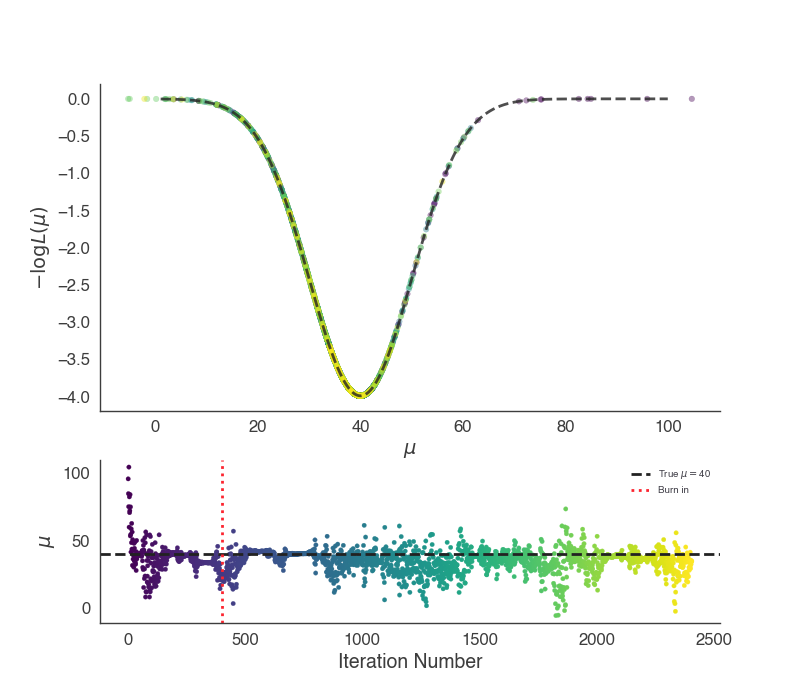

<IPython.core.display.Javascript object>


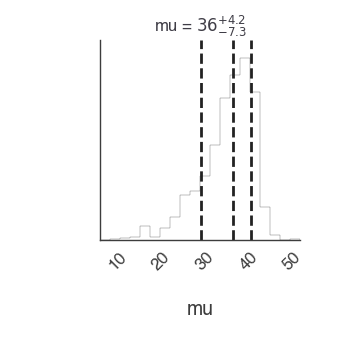

In [17]:
_ = plot_sample_path(bayes,truth=40.,burn_in=n_walkers*burn_in)
_ = bayes.results.corner_plot()

## The Zeus sampler

We now examine a more complex likelihood with [zeus](https://zeus-mcmc.readthedocs.io/en/latest/). Zeus builds upon the approach of emcee and by adding on [slice sampling](https://en.wikipedia.org/wiki/Slice_sampling).

<IPython.core.display.Javascript object>


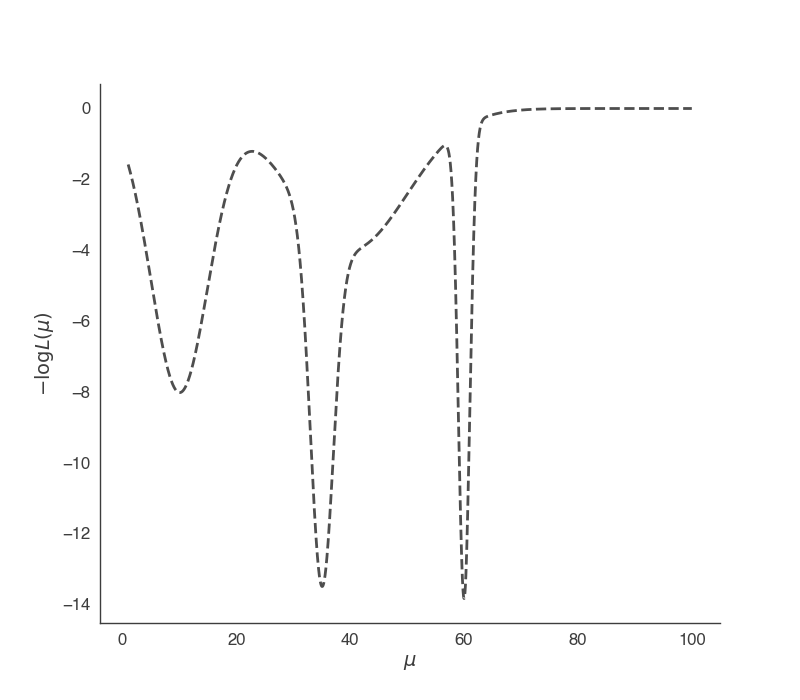

In [19]:
bayes, model = get_bayesian_analysis_object_complex_likelihood()

bayes.set_sampler('zeus')

model.test.spectrum.main.shape.mu.prior = Uniform_prior(lower_bound=1, upper_bound=100)


_ = plot_likelihood_function(bayes)

We proceed as before and see if we can fully sample the likelihood

In [20]:
model.test.spectrum.main.shape.mu = 1.
n_walkers = 4
burn_in = 100
n_samples = 500

bayes.sampler.setup(n_iterations=n_samples,n_burn_in=burn_in,n_walkers=n_walkers )

res = bayes.sample()

Initialising ensemble of 4 walkers...
Sampling progress : 100%|██████████| 600/600 [00:09<00:00, 61.35it/s] 
Summary
-------
Number of Generations: 600
Number of Parameters: 1
Number of Walkers: 4
Number of Tuning Generations: 81
Scale Factor: 0.24344
Mean Integrated Autocorrelation Time: 0.95
Effective Sample Size: 2513.65
Number of Log Probability Evaluations: 69439.0
Effective Samples per Log Probability Evaluation: 0.036199


None
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(4.7 -1.2 +1.3) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,13.838423
total,13.838423



Values of statistical measures:



,statistical measures
AIC,-29.676847
BIC,-27.676847
DIC,-46.003237
PDIC,-19.881984


<IPython.core.display.Javascript object>


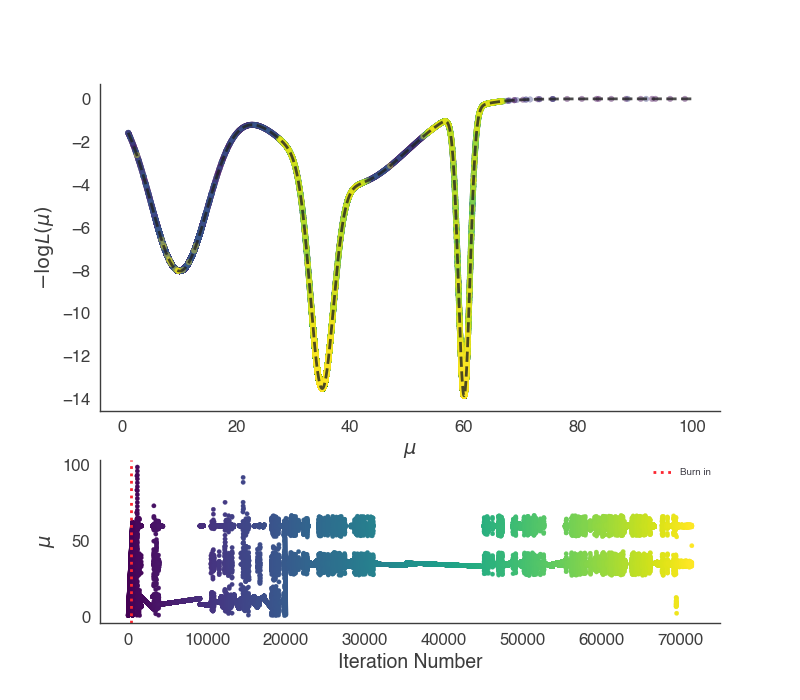

<IPython.core.display.Javascript object>


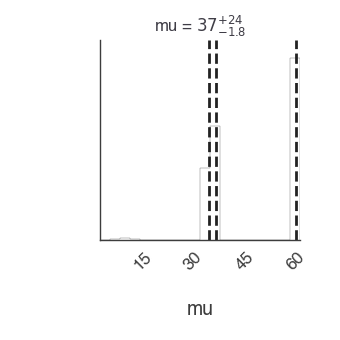

In [21]:
_ = plot_sample_path(bayes,burn_in=n_walkers*burn_in)
_ = bayes.results.corner_plot()

We see that zeus explored the parameter space, but did not sample all the modes evenly.

We can try to explode the number of samples and see if it improves.

In [22]:
model.test.spectrum.main.shape.mu = 99.
n_walkers = 4
burn_in = 200
n_samples = 1000

bayes.sampler.setup(n_iterations=n_samples,n_burn_in=burn_in,n_walkers=n_walkers )

res = bayes.sample()

Initialising ensemble of 4 walkers...
Sampling progress : 100%|██████████| 1200/1200 [00:11<00:00, 102.58it/s]
Summary
-------
Number of Generations: 1200
Number of Parameters: 1
Number of Walkers: 4
Number of Tuning Generations: 44
Scale Factor: 0.189668
Mean Integrated Autocorrelation Time: 30.58
Effective Sample Size: 156.95
Number of Log Probability Evaluations: 81915.0
Effective Samples per Log Probability Evaluation: 0.001916


None
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(3.6 -2.5 +2.4) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,13.838424
total,13.838424



Values of statistical measures:



,statistical measures
AIC,-29.676848
BIC,-27.676848
DIC,-23.055757
PDIC,0.613988


<IPython.core.display.Javascript object>


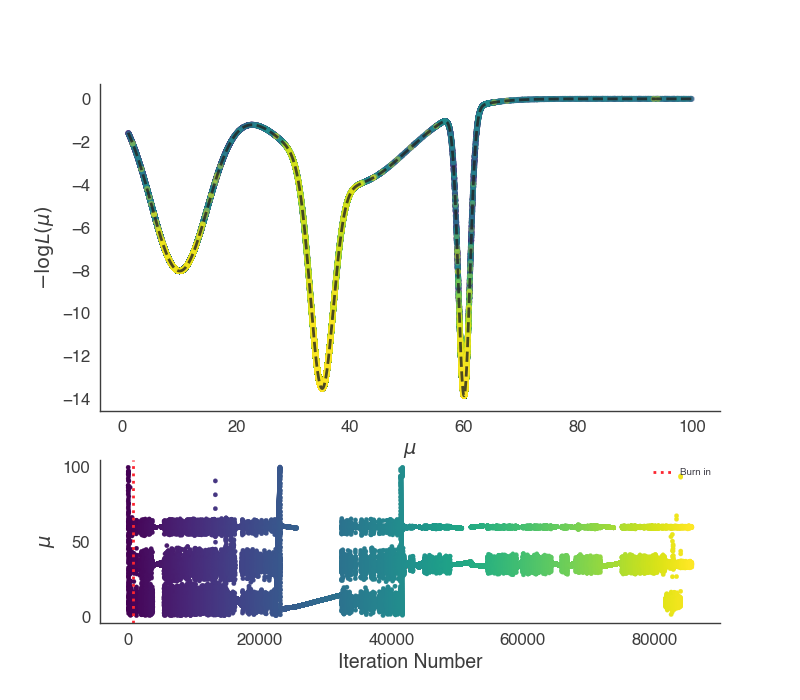

<IPython.core.display.Javascript object>


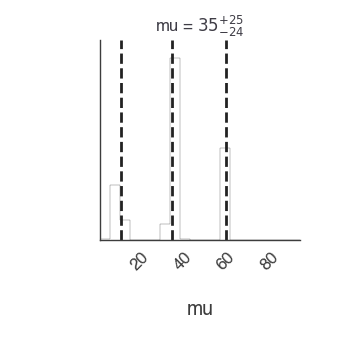

In [23]:
_ = plot_sample_path(bayes,burn_in=n_walkers*burn_in)
_ = bayes.results.corner_plot()

We can increase the number of walkers to increase the parameter space we explore.

In [20]:
n_walkers = 40
burn_in = 10
n_samples = 100

res = bayes.sample(n_walkers,burn_in,n_samples)


Mean acceptance fraction: 0.4715

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(4.0 -0.6 +2.0) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,13.838345
total,13.838345



Values of statistical measures:



,statistical measures
AIC,-29.676690
BIC,-27.676690
DIC,-39.724574
PDIC,-15.575790


<IPython.core.display.Javascript object>


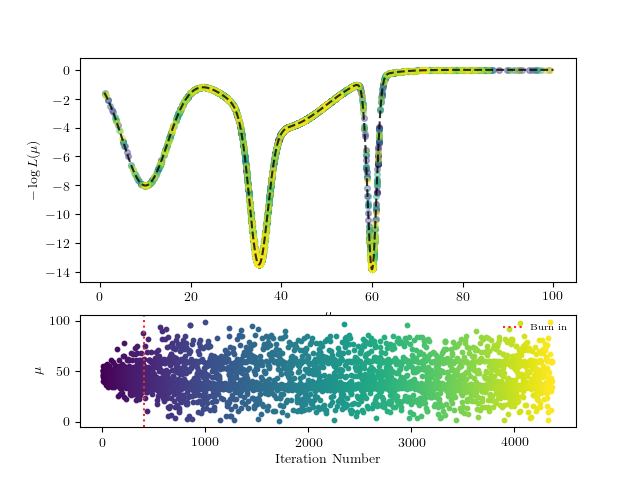

<IPython.core.display.Javascript object>


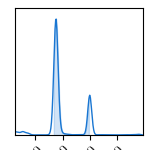

In [21]:
_ = plot_sample_path(bayes,burn_in=n_walkers*burn_in)
_ = bayes.results.corner_plot_cc()

We were able search the parameter space and resolve some modes, but it is easy to see that any inference will be diffuse. While emcee is great for highly correlated likelihoods, caution must be exercised when using it for multi-model likelihoods.

## MULTINEST

[MULTINEST](https://github.com/farhanferoz/MultiNest) is a nested sampling algorithm that is designed to integrate the the posterior to obtain the marginal likelihood. For details on the algorithm see [Feroz et al. (2009)](https://academic.oup.com/mnras/article-abstract/398/4/1601/981502), [Feroz et al. (2013)](https://arxiv.org/abs/1306.2144), and for details on the input arguments for the python interface we implement, see the documentation of [pymultinest](https://johannesbuchner.github.io/PyMultiNest/). If you find these algorithms useful for your research, please cite the originals authors!


Let's resample the complex likelihood from above with MULTINEST using 

In [22]:
res = bayes.sample_multinest(400)


Sampling

MULTINEST has its own convergence criteria... you will have to wait blindly for it to finish
If INS is enabled, one can monitor the likelihood in the terminal for completion information
  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
test.spectrum.main.Complex.mu,(4.4 -1.0 +1.6) x 10,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
custom,13.83839
total,13.83839



Values of statistical measures:



,statistical measures
AIC,-29.676781
BIC,-27.676781
DIC,-44.755248
PDIC,-18.716659
log(Z),4.298795


<IPython.core.display.Javascript object>


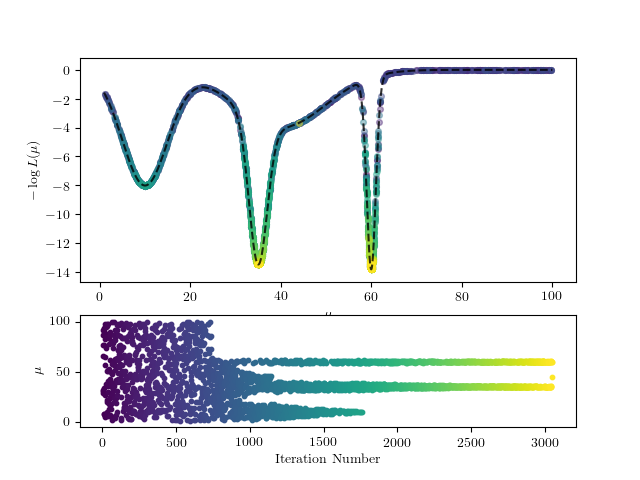

<IPython.core.display.Javascript object>


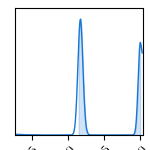

In [23]:
_ = plot_sample_path(bayes)
_ = bayes.results.corner_plot_cc()

MULTINEST has fully sampled the likelihood and broken apart the modes. Cleary point-descriptors of the results will be inefficent, but we use the output files of MULTINEST to do multi-modal analysis. For details, consult the MULTINEST documentation.

## Accessing samples and error propagation

Error propagation with posterior samples is straight forward. Say we have a function $f(\mu) = Sin(\mu)$. For the complex likelihood, we would be out of luck if we were using MLE. However, we can directly calculate $f(\mu)$ with the samples from the posterior. 

equal-tail: (1.27 -0.07 +2.3) x 10^3, hpd: (1.27 -0.06 +2.3) x 10^3


<IPython.core.display.Javascript object>


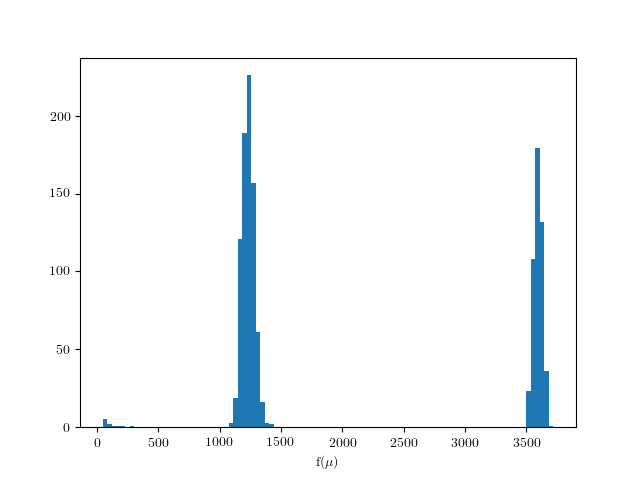

In [24]:
def f(mu):
    
    return mu**2
    
this_mu =  bayes.results.get_variates('test.spectrum.main.Complex.mu')
    
f_mu = f(this_mu)

print (f_mu)

fig, ax = plt.subplots()

ax.hist(f_mu.samples,bins=100)

_ =ax.set_xlabel(r'f($\mu$)')

As with any approach, the Bayesian capabilities of 3ML are a tool. Understanding and proper use of the posterior and marginal distributions requires special care. For further reading on the Bayesian analysis and its applications to spectral analysis check out the following resources:

* [Frequentism and bayesianism: a python-driven primer](https://arxiv.org/abs/1411.5018)
* [Bayes in the sky: Bayesian inference and model selection in cosmology](http://www.tandfonline.com/doi/abs/10.1080/00107510802066753)
* [X-ray spectral modelling of the AGN obscuring region in the CDFS: Bayesian model selection and catalogue](https://www.aanda.org/articles/aa/full_html/2014/04/aa22971-13/aa22971-13.html)
* [Analysis of energy spectra with low photon counts via Bayesian posterior simulation](http://iopscience.iop.org/article/10.1086/318656/meta)